## Analyze statistical maps

Using data created wth PrepareMaps.ipynb

Hypotheses to be tested:

Parametric effect of gain:

1. Positive effect in ventromedial PFC - for the equal indifference group
2. Positive effect in ventromedial PFC - for the equal range group
3. Positive effect in ventral striatum - for the equal indifference group
4. Positive effect in ventral striatum - for the equal range group

Parametric effect of loss:
- 5: Negative effect in VMPFC - for the equal indifference group
- 6: Negative effect in VMPFC - for the equal range group
- 7: Positive effect in amygdala - for the equal indifference group
- 8: Positive effect in amygdala - for the equal range group

Equal range vs. equal indifference:

- 9: Greater positive response to losses in amygdala for equal range condition vs. equal indifference condition.


In [1]:
import numpy,pandas
import nibabel
import json
import pickle
import os,glob
import nilearn.image
import nilearn.input_data
import nilearn.plotting
from collections import OrderedDict,Counter
import shutil
import warnings
import sklearn
import matplotlib.pyplot as plt
import seaborn
import scipy.cluster
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from utils import get_masked_data,get_metadata,get_decisions,get_teamID_to_collectionID_dict,matrix_jaccard

hypotheses= {1:'+gain: equal indiff',
            2:'+gain: equal range',
            3:'+gain: equal indiff',
            4:'+gain: equal range',
            5:'-loss: equal indiff',
            6:'-loss: equal range',
            7:'+loss: equal indiff',
            8:'+loss: equal range',
            9:'+loss:ER>EI'}

# we don't neet work with 3 and 4 because maps are the same as 2 and 3, just different regions of interest
hypnums = [1,2,5,6,7,8,9]

# create some variables used throughout
orig_dir = '/Users/poldrack/data_unsynced/NARPS/maps/orig'
output_dir = '/Users/poldrack/data_unsynced/NARPS/maps'
figure_dir = os.path.join(output_dir,'figures')
template_img = os.path.join(output_dir,'templates/MNI152_T1_2mm.nii.gz')
mask_img = os.path.join(output_dir,'templates/MNI152_T1_2mm_brain_mask.nii.gz')

cut_coords = [-24,-10,4,18,32,52,64]


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


### Load metadata

Metadata file contains details regarding the analysis of each team.

In [2]:
metadata = get_metadata()
decisions = get_decisions()
teamID_to_collectionID_dict = get_teamID_to_collectionID_dict(metadata)  

In [3]:
metadata.columns

Index(['teamID', 'NV_collection_string', 'results_comments', 'preregistered',
       'link_preregistration_form', 'regions_definition', 'softwares', 'SW',
       'Unnamed: 8', 'n_participants', 'exclusions_details',
       'used_fmriprep_data', 'preprocessing_order', 'brain_extraction',
       'segmentation', 'slice_time_correction', 'motion_correction',
       'gradient_distortion_correction', 'intra_subject_coreg',
       'distortion_correction', 'inter_subject_reg', 'intensity_correction',
       'intensity_normalization', 'noise_removal', 'volume_censoring',
       'spatial_smoothing', 'preprocessing_comments',
       'data_submitted_to_model', 'spatial_region_modeled',
       'independent_vars_first_level', 'independent_vars_higher_level',
       'model_type', 'model_settings', 'inference_contrast_effect',
       'search_region', 'statistic_type', 'pval_computation',
       'multiple_testing_correction', 'comments_analysis', 'general comments',
       'additional files?'],
      d

In [4]:
Counter(metadata.SW)

Counter({'FSL': 19,
         nan: 2,
         'SPM': 4,
         'nistats': 3,
         'randomise': 5,
         'AFNI': 9,
         'SPM12': 20,
         'Other': 2,
         'SVC': 2,
         'SPM8': 1,
         'PALM': 2,
         'SPM5': 1})

In [5]:
Counter(metadata.used_fmriprep_data)

Counter({'Yes': 36, 'No': 34})

## Diagnostics on statistical images

#### Overlap maps for thresholded images

Showing proportion of supra-threshold voxels across teams.

In [ ]:
# display overlap maps for thresholded maps


fig, ax = plt.subplots(7,1,figsize=(12,24))
for i,hyp in enumerate(hypnums):
    img=os.path.join(output_dir,'thresh_mean/hypo%d.nii.gz'%hyp)
    nilearn.plotting.plot_stat_map(img, threshold=0.1, display_mode="z", 
                colorbar=True,title='hyp %d:'%hyp+hypotheses[hyp],vmax=1.,cmap='jet',
                                  cut_coords = cut_coords,axes = ax[i],figure=fig)
plt.savefig(os.path.join(figure_dir,'overlap_map.pdf'))


#### Range and standard deviation maps

Showing range/standard deviation of statistical values in unthresholded maps across teams

In [ ]:
# show range maps
#fig = plt.fig
fig, ax = plt.subplots(7,1,figsize=(12,24))
for i,hyp in enumerate(hypnums):
    range_img=nibabel.load(os.path.join(output_dir,'unthresh_range/hypo%d.nii.gz'%hyp))
    nilearn.plotting.plot_stat_map(range_img, threshold=.1, display_mode="z", 
                           colorbar=True,title='Range: hyp %d:'%hyp+hypotheses[hyp],vmax=25,
                                  cut_coords = cut_coords,axes = ax[i])
plt.savefig(os.path.join(figure_dir,'range_map.pdf'))

In [ ]:
# show std maps
fig, ax = plt.subplots(7,1,figsize=(12,24))
for i,hyp in enumerate(hypnums):
    std_img=nibabel.load(os.path.join(output_dir,'unthresh_std/hypo%d.nii.gz'%hyp))
    nilearn.plotting.plot_stat_map(std_img, threshold=.1, display_mode="z", 
                           colorbar=True,title='SD: hyp %d:'%hyp+hypotheses[hyp],vmax=4,
                                   cut_coords = cut_coords,axes = ax[i])
plt.savefig(os.path.join(figure_dir,'std_map.pdf'))

#### Display unthresholded maps 

Display rectified unthresholded maps for each team and compute some statistics on them.

In [ ]:
imgtype='unthresh'
imginfo = {}
plot_data=True
show_md = False
nnz = []
nonzero_volume = []

dim_values = []
missing_metadata = []


for hyp in hypnums:
    hmaps = glob.glob(os.path.join(output_dir,'rectified/*/hypo%d_unthresh.nii.gz'%hyp))
    hmaps.sort()
    fig, ax = plt.subplots(len(hmaps),1,figsize=(12,len(hmaps)*2.5))
    print('making figure for hypothesis',hyp)
    # load all maps and get dims
    for i,m in enumerate(hmaps):
        img = nibabel.load(m)
        collection = m.split('/')[-2]
        collection_string,teamID = collection.split('_')
        dims = img.header.get_data_shape()
        dim_values.append(dims)
        
        md = metadata.query('NV_collection_string == "%s"'%collection_string).replace(numpy.nan,'na')
        if md.shape[0]==0:
            # try other identifier
            md = metadata.query('teamID == "%s"'%teamID)
            if md.shape[0]==0:
                missing_metadata.append(collection)
                continue
        qform = img.header.get_qform()

        # check for thresholding
        imgdata=img.get_data()
        nonzero_vox = numpy.nonzero(imgdata)
        n_nonzero_vox = len(nonzero_vox[0])
        nnz.append(n_nonzero_vox)
        vox_vol = numpy.prod(dims)
        nonzero_volume.append(n_nonzero_vox*vox_vol)
        #print(collection,dims, numpy.prod(dims),n_nonzero_vox*vox_vol)
        if show_md:
            print(md['inter_subject_reg'].values)
        if plot_data:
            if md['used_fmriprep_data'].values[0].find('Yes')>-1:
                prep_string = 'fmriprep'
            else:
                prep_string = 'other'
            nilearn.plotting.plot_stat_map(img, threshold=2., display_mode="z", 
                           colorbar=True,title='_'.join([collection,md['SW'].values[0],prep_string]),
                                          cut_coords = cut_coords,axes=ax[i])
    if plot_data:
        plt.savefig(os.path.join(figure_dir,'hyp%d_individual_maps.pdf'%hyp))


#### Correlation maps for unthresholded images

Load the unthresholded images and compute the correlation between 

hypothesis 1
hypothesis 2
hypothesis 5
hypothesis 6
hypothesis 7
hypothesis 8
hypothesis 9


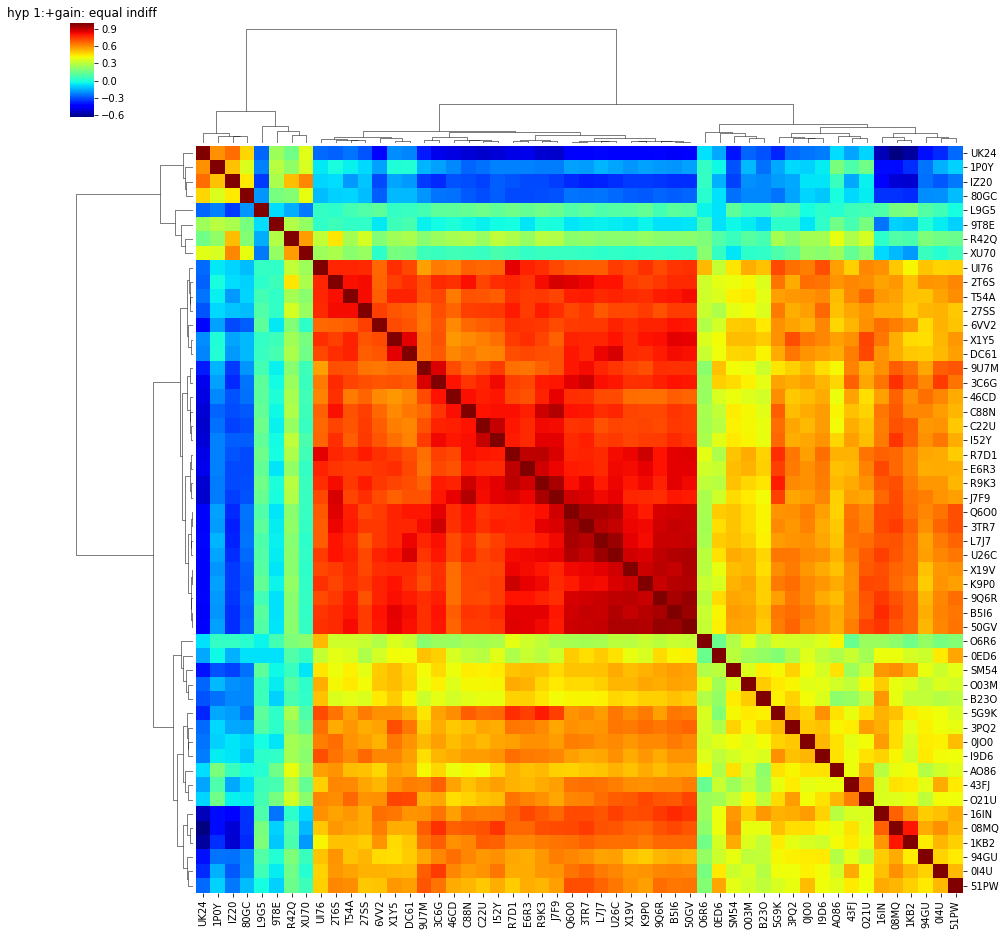

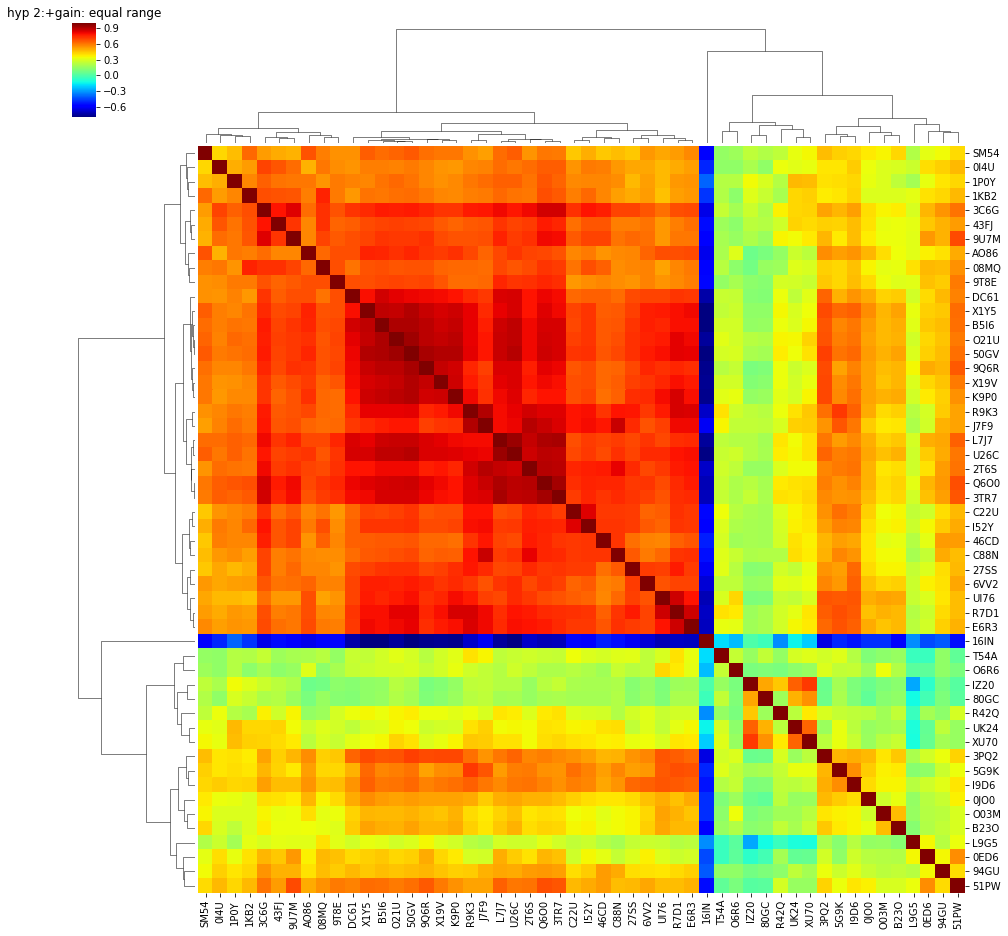

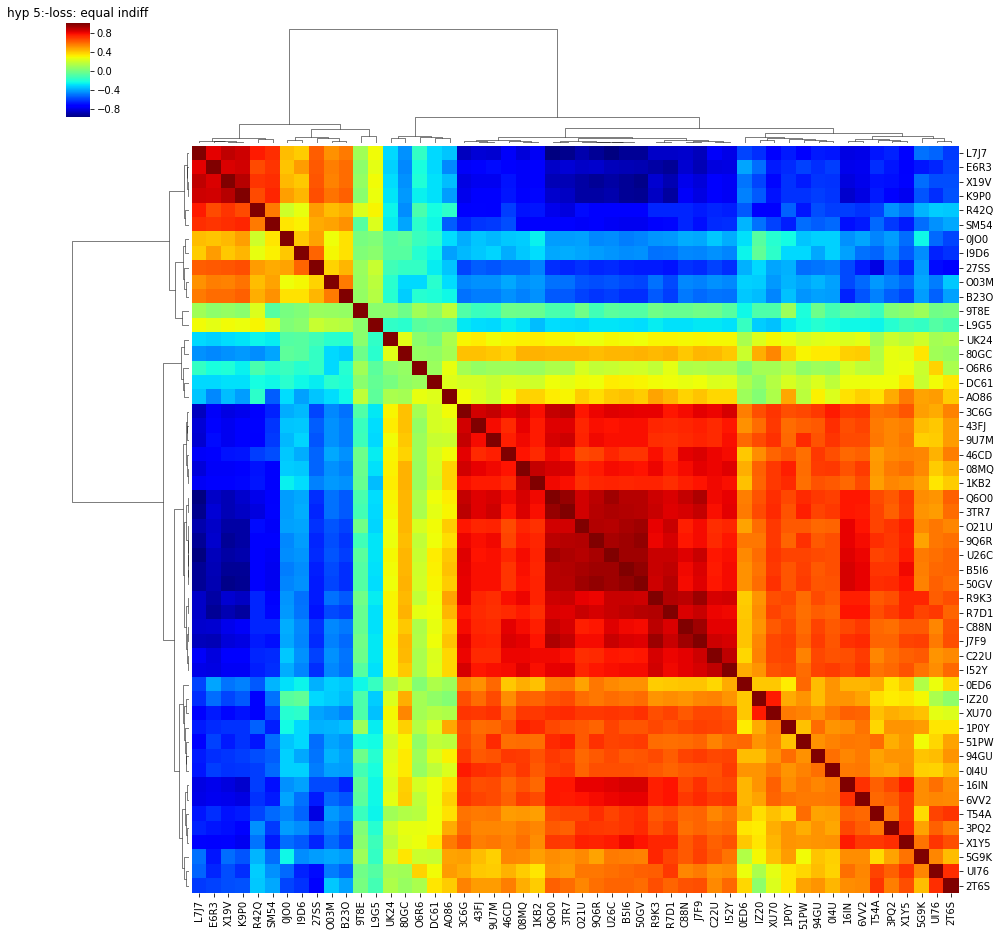

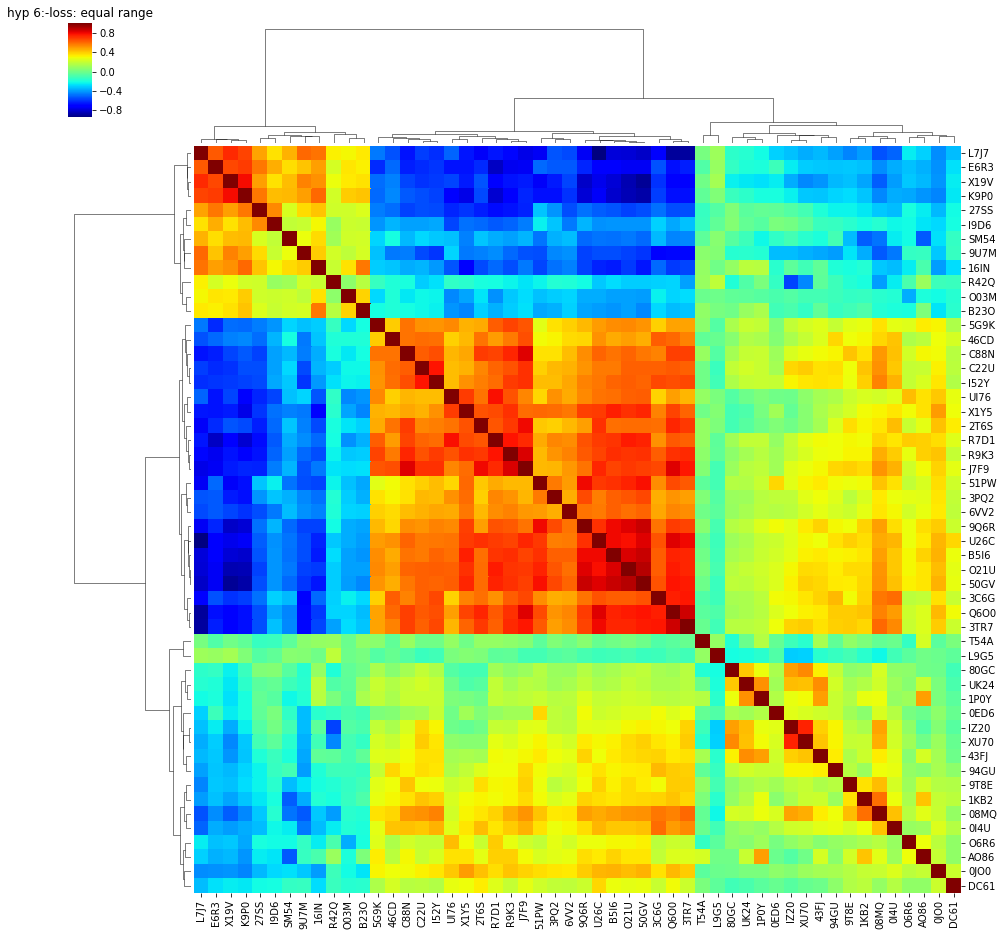

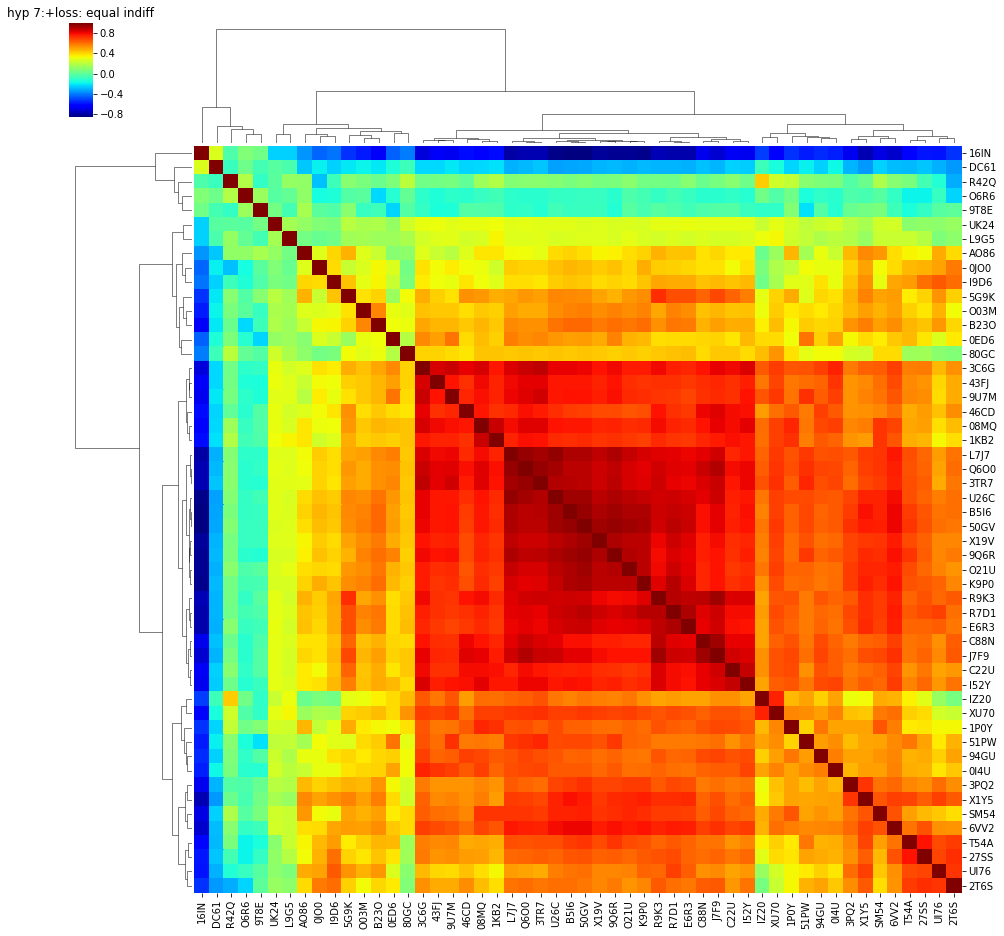

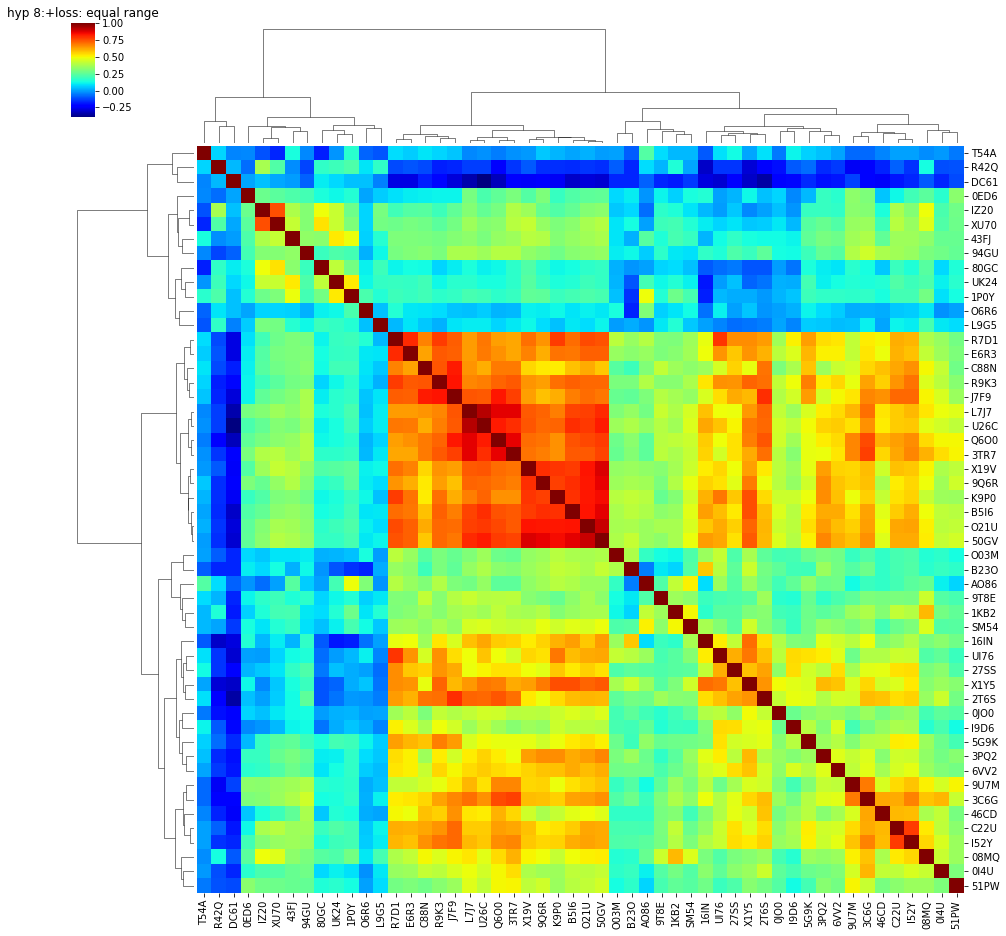

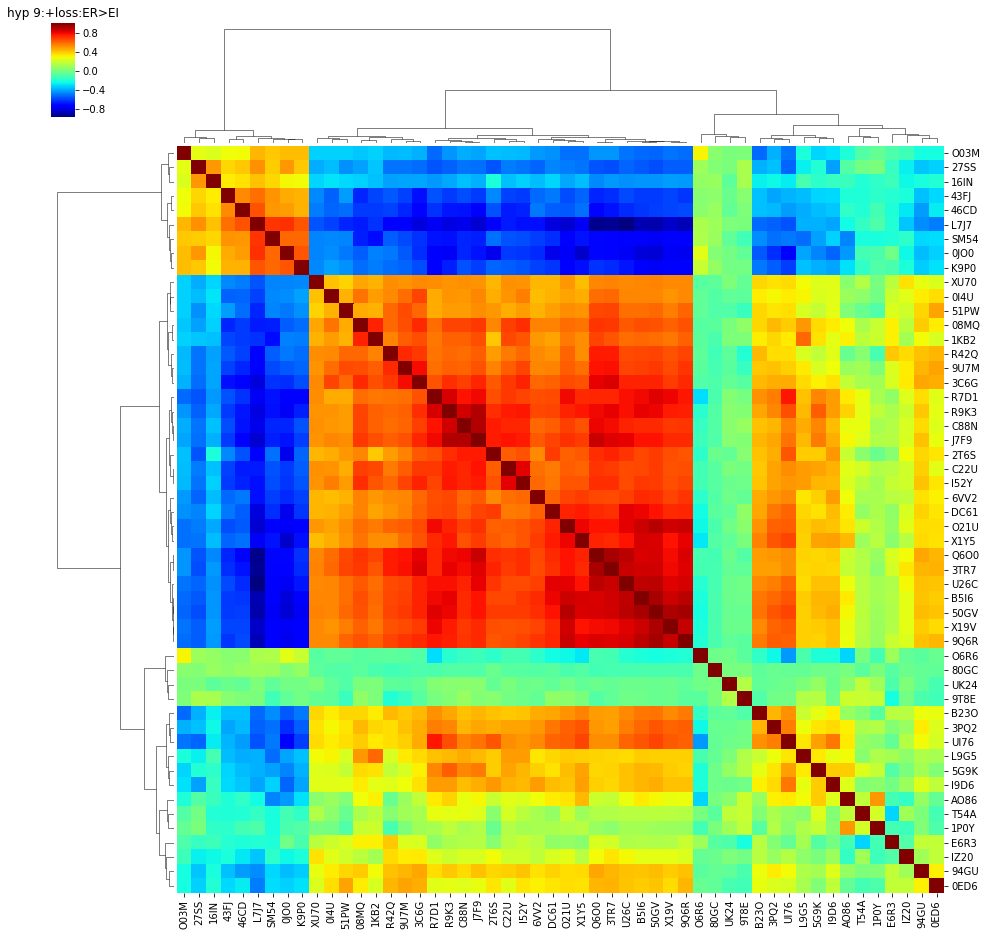

In [26]:
dendrograms = {}
membership={}

corr_type = 'spearman'
n_clusters = 4

cc_unthresh={}
for i,hyp in [1]: # enumerate(hypnums):
    print('hypothesis',hyp)
    maskdata,labels = get_masked_data(hyp,mask_img,output_dir)        
    if corr_type == 'spearman':
        cc = scipy.stats.spearmanr(maskdata.T).correlation
    else:
        cc = numpy.corrcoef(maskdata)
    cc = numpy.nan_to_num(cc)
    df = pandas.DataFrame(cc,index=labels,columns=labels)
    
    
    # Create a categorical palette to identify the networks
network_pal = sns.husl_palette(8, s=.45)
network_lut = dict(zip(map(str, used_networks), network_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = df.columns.get_level_values("network")
network_colors = pd.Series(networks, index=df.columns).map(network_lut)

# Draw the full plot
sns.clustermap(df.corr(), center=0, cmap="vlag",
               row_colors=network_colors, col_colors=network_colors,
               linewidths=.75, figsize=(13, 13))
    cm = seaborn.clustermap(df,cmap='jet',figsize=(16,16),method='ward')
    plt.title('hyp %d:'%hyp+hypotheses[hyp])
    cc_unthresh[hyp]=(cc,labels)
    plt.savefig(os.path.join(figure_dir,'hyp%d_%s_map_unthresh.pdf'%(hyp,corr_type)))
    dendrograms[hyp]=cm.dendrogram_row.linkage
    
    # get cluster membership
    membership[hyp]={}
    clustlabels = scipy.cluster.hierarchy.cut_tree(dendrograms[hyp],n_clusters=n_clusters)
    for j in cm.dendrogram_row.reordered_ind:
        cl=clustlabels[j][0]
        if not cl in membership[hyp]:
            membership[hyp][cl]=[]
        membership[hyp][cl].append(labels[j])

    
with open(os.path.join(output_dir,'unthresh_clustering_%s.pkl'%corr_type),'wb') as f:
    pickle.dump((dendrograms,membership),f)  

### Clustering of unthresholded images

Use dendrogram computed by seaborn clustermap to identify clusters, and then create separate mean statstical map for each cluster.
N=4 was selected based on visualization of the clustering solutions.

*NB*: The cluster numbers do not align with the ordering of the clusters from left to right in the heatmap dendrograms.


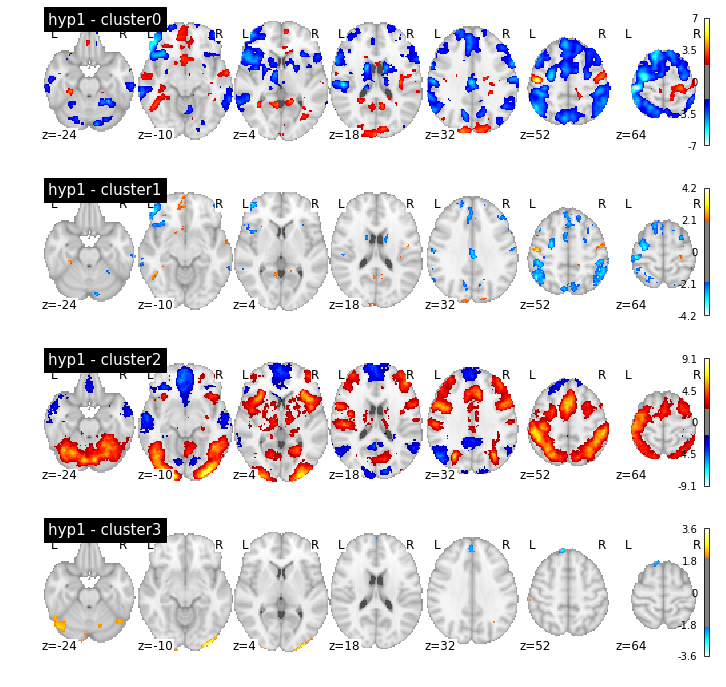

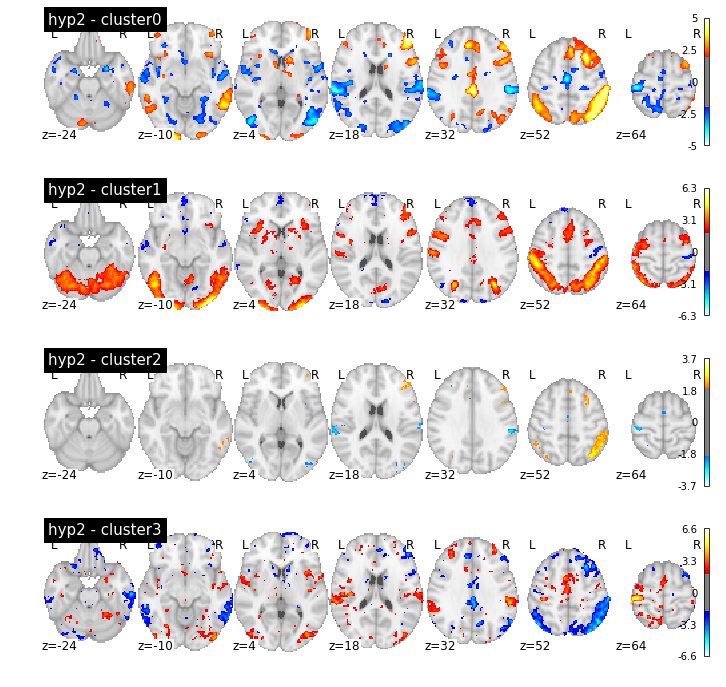

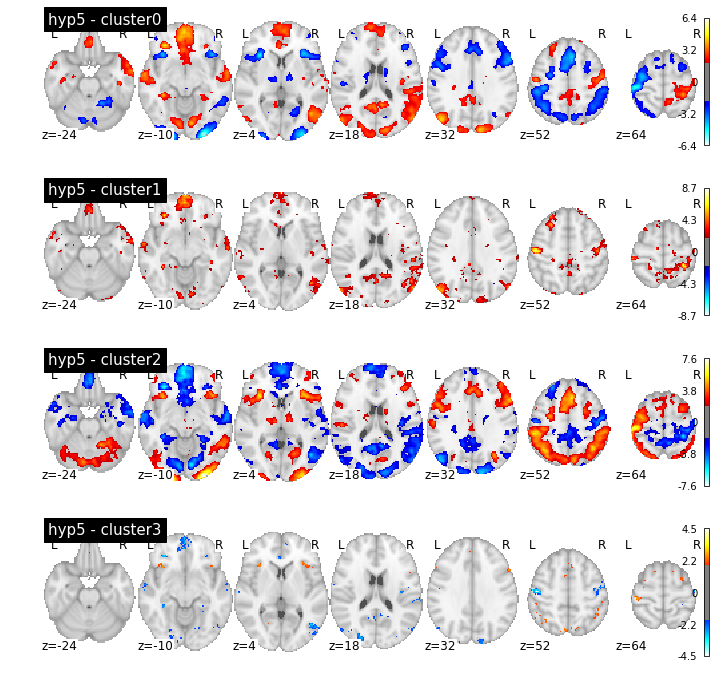

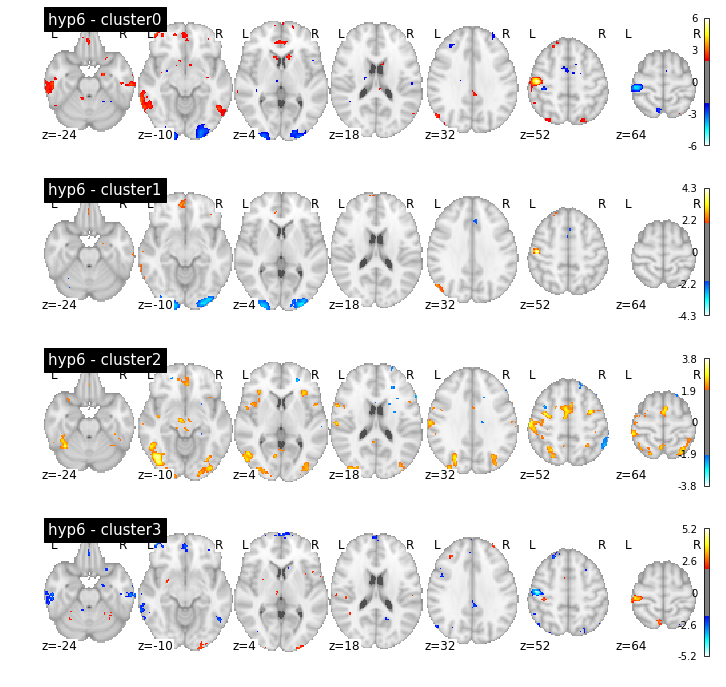

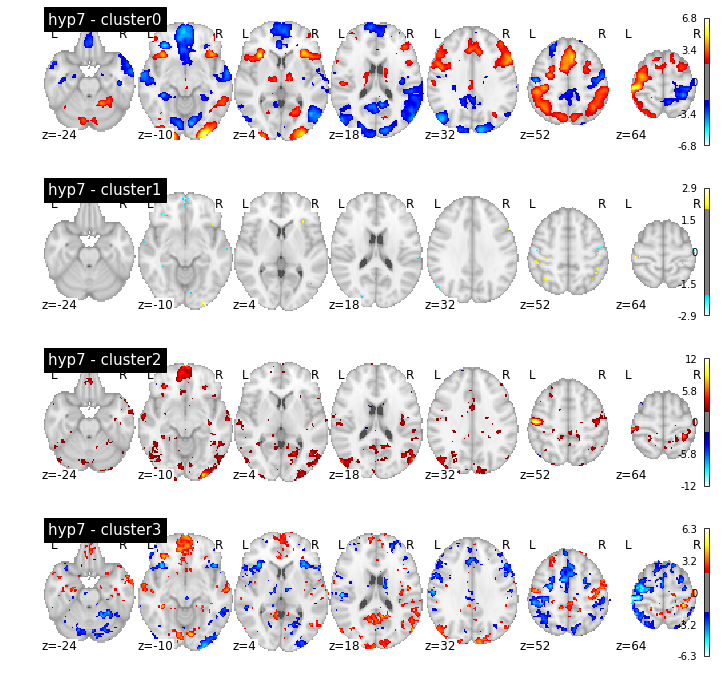

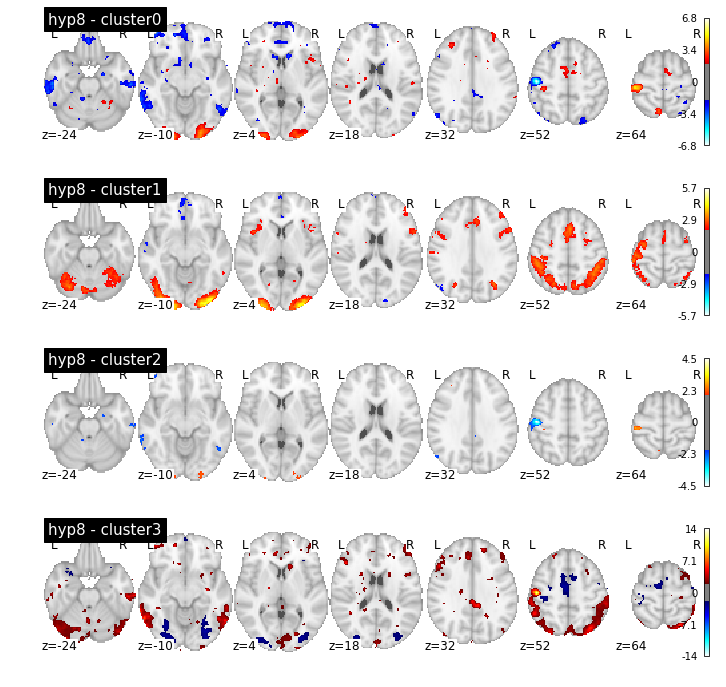

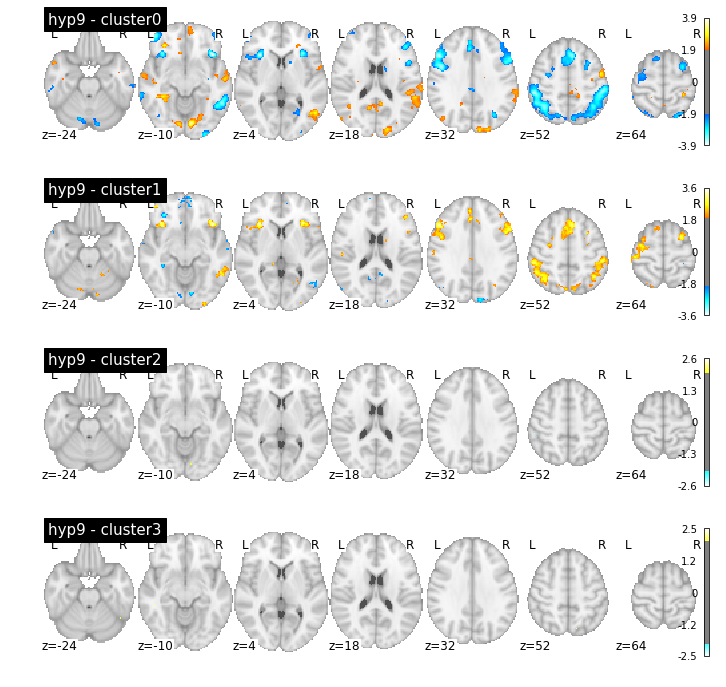

In [27]:
# use clustering from seaborn to separate the different clusters into images

corr_type = 'spearman'

# Ensure variable is defined
try:
    dendrograms
    membership
except NameError:
    with open(os.path.join(output_dir,'unthresh_dendrograms_%s.pkl'%corr_type),'rb') as f:
        dendrograms,membership = pickle.load(f)  

n_clusters=4
masker = nilearn.input_data.NiftiMasker(mask_img=mask_img)

for i,hyp in enumerate(hypnums):
    print('hyp',hyp)
    fig, ax = plt.subplots(n_clusters,1,figsize=(12,12))
    clusters = list(membership[hyp].keys())
    clusters.sort()

    for i,cl in enumerate(clusters):
        # get all images for this cluster and average them
        member_maps = []
        for member in membership[hyp][cl]:
            cid = get_teamID_to_collectionID_dict(metadata)[member]
            member_maps.append(os.path.join(output_dir,'rectified/%s/hypo%d_unthresh.nii.gz'%(cid,hyp)))
        maskdata = masker.fit_transform(member_maps)
        meandata = numpy.mean(maskdata,0)
        mean_img = masker.inverse_transform(meandata)
        
        nilearn.plotting.plot_stat_map(mean_img, threshold=2., display_mode="z", 
                    colorbar=True,title='hyp%d - cluster%d'%(hyp,cl),
                            cut_coords = cut_coords,axes=ax[i])

    plt.savefig(os.path.join(figure_dir,'hyp%d_cluster_means.pdf'%hyp))
        

In [28]:
# create a data frame containing cluster metadata

cluster_metadata={}
cluster_metadata_df = pandas.DataFrame(columns = ['hyp%d'%i for i in hypnums],
                                      index=metadata.teamID)
for i,hyp in enumerate(hypnums):
    cluster_metadata[hyp]={}
    print('Hypothesis',hyp)
    clusters = list(membership[hyp].keys())
    clusters.sort()
    for i,cl in enumerate(clusters):
        print('cluster',cl)
        print(membership[hyp][cl])
        cluster_metadata[hyp][cl]=metadata[metadata.teamID.isin(membership[hyp][cl])]
        for m in membership[hyp][cl]:
            cluster_metadata_df.loc[m,'hyp%d'%hyp]=cl
        
    print('')

cluster_metadata_df = cluster_metadata_df.dropna()

        

Hypothesis 1
cluster 0
['UI76', '2T6S', 'T54A', '27SS', '6VV2', 'X1Y5', 'DC61', '9U7M', '3C6G', '46CD', 'C88N', 'C22U', 'I52Y', 'R7D1', 'E6R3', 'R9K3', 'J7F9', 'Q6O0', '3TR7', 'L7J7', 'U26C', 'X19V', 'K9P0', '9Q6R', 'B5I6', '50GV']
cluster 1
['O6R6', '0ED6', 'SM54', 'O03M', 'B23O', '5G9K', '3PQ2', '0JO0', 'I9D6', 'AO86', '43FJ', 'O21U', '16IN', '08MQ', '1KB2', '94GU', '0I4U', '51PW']
cluster 2
['UK24', '1P0Y', 'IZ20', '80GC']
cluster 3
['L9G5', '9T8E', 'R42Q', 'XU70']

Hypothesis 2
cluster 0
['SM54', '0I4U', '1P0Y', '1KB2', '3C6G', '43FJ', '9U7M', 'AO86', '08MQ', '9T8E', 'DC61', 'X1Y5', 'B5I6', 'O21U', '50GV', '9Q6R', 'X19V', 'K9P0', 'R9K3', 'J7F9', 'L7J7', 'U26C', '2T6S', 'Q6O0', '3TR7', 'C22U', 'I52Y', '46CD', 'C88N', '27SS', '6VV2', 'UI76', 'R7D1', 'E6R3']
cluster 1
['T54A', 'O6R6', 'IZ20', '80GC', 'R42Q', 'UK24', 'XU70']
cluster 2
['3PQ2', '5G9K', 'I9D6', '0JO0', 'O03M', 'B23O', 'L9G5', '0ED6', '94GU', '51PW']
cluster 3
['16IN']

Hypothesis 5
cluster 0
['3C6G', '43FJ', '9U7M', '46C

### Determine clustering similarity across hypotheses

For each pair of hypotheses, compute the adjusted Rand index to determine whether teams are similarly clustered across hypotheses.


In [15]:
# create membership data frame for computing cluster similarity across hypotheses

randmtx = numpy.zeros((10,10))
for i,j in enumerate(hypnums):
    for k in hypnums[i:]:
        if j==k:
            continue
        randmtx[j,k]=sklearn.metrics.adjusted_rand_score(cluster_metadata_df['hyp%d'%j],cluster_metadata_df['hyp%d'%k])
        if randmtx[j,k]>.2:
            print(j,k,randmtx[j,k])
        


1 2 0.4328105599755839
1 6 0.20334781787266198
1 7 0.24093890480348087
1 8 0.45963731312872136
1 9 0.3094660288268451
2 7 0.27401801221518046
2 8 0.3046654028831897
2 9 0.33052948241082986
5 6 0.42656351624276867
6 8 0.2050462204917293
6 9 0.2958891242975542
7 8 0.5350098991576584
7 9 0.28496696376551095
8 9 0.24982228954956057


### Determine distance from mean and compare across hypotheses



In [75]:
mean_corr=pandas.DataFrame(numpy.zeros((len(labels),len(hypnums))),
                                columns = ['hyp%d'%i for i in hypnums],
                                index=labels)
for i,hyp in enumerate(hypnums):
    print('hypothesis',hyp)
    maskdata,labels = get_masked_data(hyp,mask_img,output_dir)   
    meandata = numpy.mean(maskdata,0)
    for t in range(maskdata.shape[0]):
        mean_corr.iloc[t,i] = scipy.stats.spearmanr(maskdata[t,:],meandata).correlation

hypothesis 1
hypothesis 2
hypothesis 5
hypothesis 6
hypothesis 7
hypothesis 8
hypothesis 9


#### Is distance from the mean similar across hypotheses?



In [78]:
mean_corr.corr(method='spearman')

,hyp1,hyp2,hyp5,hyp6,hyp7,hyp8,hyp9
hyp1,1.000000,0.846581,0.458123,0.405788,0.734483,0.800393,0.582430
hyp2,0.846581,1.000000,0.494920,0.510373,0.807991,0.848203,0.624008
hyp5,0.458123,0.494920,1.000000,0.877060,0.605481,0.526680,0.714761
hyp6,0.405788,0.510373,0.877060,1.000000,0.549304,0.517288,0.695467
hyp7,0.734483,0.807991,0.605481,0.549304,1.000000,0.886451,0.594638
hyp8,0.800393,0.848203,0.526680,0.517288,0.886451,1.000000,0.590199
hyp9,0.582430,0.624008,0.714761,0.695467,0.594638,0.590199,1.000000


### Plot distance from mean across teams

This plot is limited to the teams with particularly low median correlations (<.4)

<BarContainer object of 10 artists>

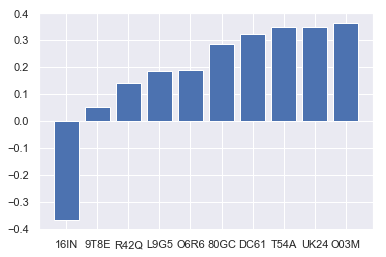

In [85]:
mean_distance = mean_corr.median(1).sort_values()
mean_distance = mean_distance[mean_distance<0.4]
plt.bar(mean_distance.index,mean_distance)

### Closer look at metadata

Focusing on Hypothesis 1, for each cluster print a summary of the metadata along with some details for each team.

In [18]:
# look more closely at the data for hyp 1, to try to better understand the clusters

hyp=1
strings_to_find = [('motion','movement'),'compcor']
for cl in range(4):
    print('cluster',cl)
    md = cluster_metadata[hyp][cl]
    print(Counter(md.SW))
    print(Counter(md.used_fmriprep_data))
    found={}
    for s in strings_to_find:
        found[s]=[]
    for i in md.index:
        print(i,md.loc[i,'SW'],md.loc[i,'used_fmriprep_data'])
        for s in strings_to_find:
            if isinstance(s, tuple):
                for ss in s:
                     if md.loc[i,'independent_vars_first_level'].lower().find(ss)>-1:
                        found[s].append(i)
                        #print('found possible use of',s[0])
               
            else:
                if md.loc[i,'independent_vars_first_level'].lower().find(s)>-1:
                    found[s].append(i)
                    #print('found possible use of',s)
        print(md.loc[i,'independent_vars_first_level'])
        print('')
    for s in strings_to_find:
        if isinstance(s, tuple):
            ss=s[0]
        else:
            ss=s
        print('found possible modeling of %s in %0.2f percent'%(ss,100*(len(found[s])/md.shape[0])))
    print('')

cluster 0
Counter({'SPM12': 8, 'FSL': 5, 'randomise': 4, 'AFNI': 4, 'SPM': 3, nan: 2})
Counter({'Yes': 18, 'No': 8})
50GV FSL Yes
In FSL FEAT, we used an event-related design with three predictors: (1) the duration of the gamble choice period, (2) parametric modulation of the gain amount, and (3) parametric modulation of the loss amount. All 3 regressors were convolved with a double-gamma HRF. No orthogonalization of regressors was applied.

9Q6R FSL No
Event-related design predictors:
- Modeled duration = 4
- EVs  (3): Mean-centered Gain, Mean-Centered Loss, Events (constant)
Block design:
- baseline not explicitly modeled
HRF:
- FMRIB's Linear Optimal Basis Sets
Movement regressors:
- FD, six parameters (x, y, z, RotX, RotY, RotZ)

U26C nan Yes
First-level analyses were performed using a GLM in an event related design. Stimulus onsets (gambling task) were convolved with the canonical HRF basis function as provided by the SPM with a stimulus duration of 4 s. We additionally included t

### Number of active voxels

For each hypothesis, plot the distribution of # of suprathreshold voxels across teams

In [20]:
n_active = pandas.DataFrame(columns=['hyp','p_active','team'])
for hyp in [1,2,5,6,7,8,9]:
    maskdata,labels = get_masked_data(hyp,mask_img,output_dir,imgtype='thresh')
    tmp = pandas.DataFrame({'n_active':numpy.sum(maskdata,1),
                            'hyp':(numpy.ones(maskdata.shape[0])*hyp).astype('int'),
                           'team':labels})
    n_active = pandas.concat((n_active,tmp))
    


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


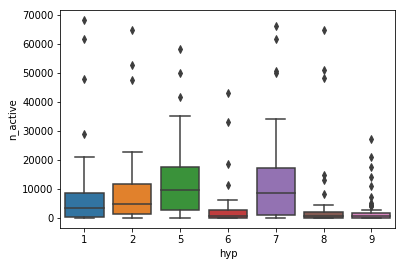

In [21]:
seaborn.boxplot(x="hyp", y="n_active", data=n_active)
plt.savefig(os.path.join(figure_dir,'n_active_voxels.pdf'))

#### Similarity maps for thresholded images

For each pair of thresholded images, compute the similarity of the thresholded/binarized maps using the Jaccard coefficient.

In [ ]:
# get jaccard comparisons

cc_thresh={}
get_jaccard = False
for hyp in [1,2,5,6,7,8,9]:
    maskdata,labels = get_masked_data(hyp,mask_img,output_dir,imgtype='thresh')
    cc = matrix_jaccard(maskdata)
    df = pandas.DataFrame(cc,index=labels,columns=labels)
    cc_thresh[hyp]=df


In [ ]:
for hyp in [1,2,5,6,7,8,9]:
    df = cc_thresh[hyp]
    seaborn.clustermap(df,cmap='jet',figsize=(16,16),method='ward')
    plt.title(hypotheses[hyp])
    plt.savefig(os.path.join(figure_dir,'hyp%d_jaccard_map_thresh.pdf'%hyp))

In [ ]:
# how is it that VMPFC agreement is so good for negative loss but not for positive gain?


In [ ]:
# compute map similarity for fmriprep studies versus others


for hyp in [1,2,5,6,7,8,9]:
    cc,labels = cc_unthresh[hyp]
    md = metadata.reindex(labels)
    fmriprep_used = md['used_fmriprep_data']=='Yes'
    cc_fmriprep_fmriprep = []
    cc_fmriprep_other = []
    cc_other_other = []
    for i in range(cc.shape[0]):
        for j in range(i+1,cc.shape[1]):
            if fmriprep_used[i] and fmriprep_used[j]:
                cc_fmriprep_fmriprep.append(cc[i,j])
            elif not fmriprep_used[i] and not fmriprep_used[j]:
                cc_other_other.append(cc[i,j])
            else:
                cc_fmriprep_other.append(cc[i,j])
    
    fmriprep_mean_sim = numpy.mean(numpy.array(cc_fmriprep_fmriprep))
    other_mean_sim = numpy.mean(numpy.array(cc_other_other))
    fmriprep_vs_other_mean_sim = numpy.mean(numpy.array(cc_fmriprep_other))
    print(hypotheses[hyp])
    print('fmriprep mean similarity:',fmriprep_mean_sim)
    print('other mean similarity:',other_mean_sim)
    print('fmriprep vs other mean similarity:',fmriprep_vs_other_mean_sim)
    print('')

In [ ]:
for hyp in [1,2,5,6,7,8,9]:
    cc,labels = cc_unthresh[hyp]
    md = metadata.reindex(labels)
    cc_fsl = cc[md['SW']=='FSL',:]
    cc_fsl = cc_fsl[:,md['SW']=='FSL']
    cc_spm12 = cc[md['SW']=='SPM12',:]
    cc_spm12 = cc_spm12[:,md['SW']=='SPM12']
    cc_bw = cc[md['SW']=='SPM12',:]
    cc_bw = cc_spm12[:,md['SW']=='SPM12']
    
    fsl_mean_sim = numpy.mean(cc_fsl[numpy.triu_indices_from(cc_fsl)])
    spm12_mean_sim = numpy.mean(cc_spm12[numpy.triu_indices_from(cc_spm12)])
    print(hypotheses[hyp])
    print('fsl mean similarity:',fsl_mean_sim)
    print('spm12 mean similarity:',spm12_mean_sim)
    print('')

In [ ]:
### compare image similarity to mean in relation to confidence of team
